In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import sqlite3
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("../database.db")

df = pd.read_sql("SELECT * FROM Ticker_1H WHERE Ticker = 'MSFT'", con=conn)
df.head()

,Datetime,Open,High,Low,Close,Volume,Ticker,InsertTime
0,2024-01-16 09:30:00.000000,392.750000,393.700012,389.470001,392.119995,8262760,MSFT,2026-01-13 11:05:14.285670
1,2024-01-16 10:30:00.000000,392.095001,393.220001,390.320007,391.649994,3330125,MSFT,2026-01-13 11:05:14.285670
2,2024-01-16 11:30:00.000000,391.690002,392.319885,389.730011,389.779999,2038955,MSFT,2026-01-13 11:05:14.285670
3,2024-01-16 12:30:00.000000,389.760010,390.000000,387.622894,389.010010,2296409,MSFT,2026-01-13 11:05:14.285670
4,2024-01-16 13:30:00.000000,389.019989,389.750000,388.000000,388.662994,1597837,MSFT,2026-01-13 11:05:14.285670


In [3]:
df.Ticker.drop_duplicates().to_numpy()

array(['MSFT'], dtype=object)

In [4]:
df = df[["Datetime", "Open", "High", "Low", "Close", "Volume"]]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")
df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-01-16 09:30:00,392.750000,393.700012,389.470001,392.119995,8262760
2024-01-16 10:30:00,392.095001,393.220001,390.320007,391.649994,3330125
2024-01-16 11:30:00,391.690002,392.319885,389.730011,389.779999,2038955
2024-01-16 12:30:00,389.760010,390.000000,387.622894,389.010010,2296409
2024-01-16 13:30:00,389.019989,389.750000,388.000000,388.662994,1597837


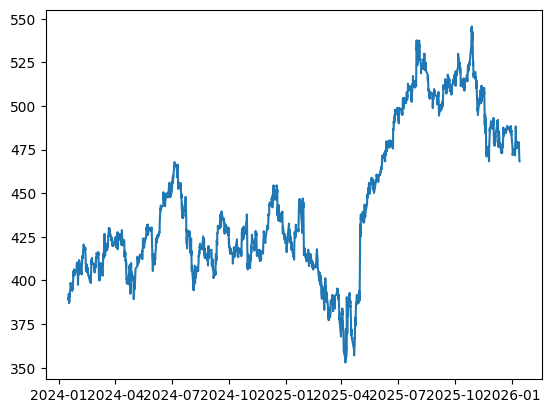

In [5]:
plt.plot(df.index, df.Close)

In [20]:
from sklearn.preprocessing import StandardScaler

train_size = 2800
val_size = 300

df_np = df.to_numpy()
scale_to = df.to_numpy()[:train_size]
labels = df.Close.to_numpy()

scaler = StandardScaler()
scaler.fit(scale_to)

df_np = scaler.transform(df_np)

In [24]:
def create_window(predictors, labels, window_size=5):
    df_np = predictors
    X = []
    y = []


    for i in range(len(df_np) - window_size):
        row = np.array([[a] for a in df_np[i:i+window_size]]).reshape(window_size, 5) # Does [[a] [b] [c]...]
        label = labels[i+window_size]

        X.append(row)
        y.append(label)

    return np.array(X), np.array(y)

In [25]:
X, y = create_window(df_np, labels, 5)
X.shape, y.shape

((3473, 5, 5), (3473,))

In [26]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2800, 5, 5), (2800,), (300, 5, 5), (300,), (373, 5, 5), (373,))

In [ ]:
# X_train, y_train = X_train.reshape(X_train.shape[:3]), y_train.reshape(y_train.shape[:3])
# X_val, y_val = X_val.reshape(X_val.shape[:3]), y_val.reshape(y_val.shape[:3])
# X_test, y_test = X_test.reshape(X_test.shape[:3]), y_test.reshape(y_test.shape[:3])

# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2800, 5, 1), (2800, 1), (300, 5, 1), (300, 1), (373, 5, 1), (373, 1))

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [28]:
model1 = Sequential()
model1.add(InputLayer((5, 5)))
model1.add(LSTM(128))
model1.add(Dense(8, "relu"))
model1.add(Dense(1, "linear"))

model1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,649 (272.07 KB)

 Trainable params: 69,649 (272.07 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
mcp = ModelCheckpoint("model1/best_model.keras", save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[mcp])

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 177009.5469 - val_loss: 248696.6406
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 146099.6875 - val_loss: 189175.0469
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 109939.8984 - val_loss: 148274.9531
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 78650.1172 - val_loss: 110173.5000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51625.8750 - val_loss: 77190.9375
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30630.5918 - val_loss: 51191.5781
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16331.7490 - val_loss: 32793.7266
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7953.1470 - val_loss: 21004.9844
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3807.6311 - val_loss: 14096.2217
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2092.4524 - val_loss: 10380.0996
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1496.

In [30]:
from tensorflow.keras.models import load_model

model1_loaded = load_model("model1/best_model.keras")

In [ ]:
y_pred = model1_loaded.predict(X_test).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [32]:
train_true = np.full((len(X)), np.nan)
val_true = np.full((len(X)), np.nan)
test_true = np.full((len(X)), np.nan)
test_pred = np.full((len(X)), np.nan)

train_true[:train_size] = y_train.flatten()
val_true[train_size:train_size+val_size] = y_val.flatten()
test_true[train_size+val_size:] = y_test.flatten()
test_pred[train_size+val_size:] = y_pred


In [33]:
graph_df = pd.DataFrame({
    "Train-True": train_true, 
    "Val-True": val_true, 
    "Test-True": test_true, 
    "Test-Preds": test_pred})
graph_df

,Train-True,Val-True,Test-True,Test-Preds
0,389.470001,NaN,NaN,NaN
1,390.269989,NaN,NaN,NaN
2,387.010010,NaN,NaN,NaN
3,389.209991,NaN,NaN,NaN
4,388.720001,NaN,NaN,NaN
...,...,...,...,...
3468,NaN,NaN,479.140015,477.920349
3469,NaN,NaN,479.239990,478.118500
3470,NaN,NaN,477.190002,478.950500
3471,NaN,NaN,468.239990,478.026886


<Axes: >

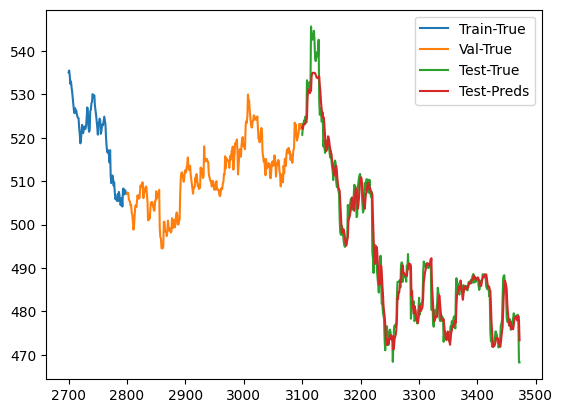

In [34]:
graph_df.iloc[2700:, :].plot()

<Axes: >

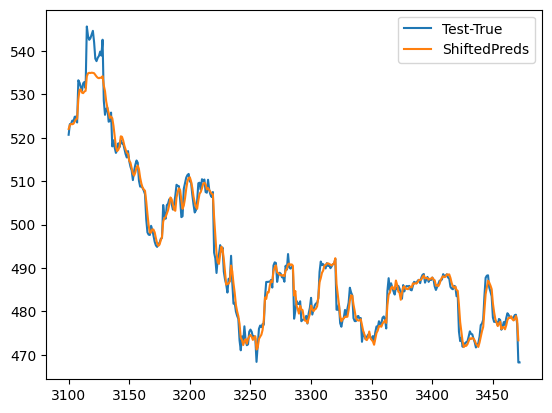

In [35]:
graph_df["ShiftedPreds"] = graph_df["Test-Preds"].shift(-1)
graph_df[["Test-True", "ShiftedPreds"]].iloc[train_size+val_size:].plot()